In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from time import time
import os

In [61]:
def dataset(data, x, lf=7):
    #Splits data into train-test format with 90% split
    #input is an x-days long sequence and output shall be 10%+ positive/ positive/ negligible(0)/ negative/ 10%+ negative
    splitval = int(data.shape[0]*0.9)
    data = data.reshape([data.shape[0], 1])
    trainx = np.zeros([x, 0])
    trainy = np.zeros([3, 0])
    testx = np.zeros([x, 0])
    testy = np.zeros([3, 0])
    print("Split value is: ", splitval)
    
    #making input for network
    for k in range(splitval-x-lf):
        trainx = np.append(trainx, data[k:k+x], axis=1)
    for l in range(splitval-x-lf, data.shape[0]-x-lf):
        testx = np.append(testx, data[l:l+x], axis=1)
        
    #making output for network
    for i in range(splitval-x-lf):
        if data[i]!=0:
            if abs(data[i+lf])<=0.02:
                trainy = np.append(trainy, np.reshape(np.array([0,1,0]), [3,1]), axis=1)
            #elif 0.1>=(data[i+lf]-data[i])/data[i]>0.02:
             #   trainy = np.append(trainy, np.reshape(np.array([0,1,0,0,0]), [5,1]), axis=1)
            elif data[i+lf]>0.02:
                trainy = np.append(trainy, np.reshape(np.array([1,0,0,]), [3,1]), axis=1)
            #elif -0.1<(data[i+lf]-data[i])/data[i]<-0.02:
             #   trainy = np.append(trainy, np.reshape(np.array([0,0,0,1,0]), [5,1]), axis=1)
            elif data[i+lf]<-0.02:
                trainy = np.append(trainy, np.reshape(np.array([0,0,1]), [3,1]), axis=1)
            else:
                trainy = np.append(trainy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
        else:
            trainy = np.append(trainy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
    for j in range(splitval-x-lf, data.shape[0]-x-lf):
        if data[j]!=0:
            if abs(data[j+lf])<=0.02:
                testy = np.append(testy, np.reshape(np.array([0,1,0]), [3,1]), axis=1)
            #elif 0.1>=(data[j+lf]-data[j])/data[j]>0.02:
             #   testy = np.append(testy, np.reshape(np.array([0,1,0,0,0]), [5,1]), axis=1)
            elif data[j+lf]>0.02:
                testy = np.append(testy, np.reshape(np.array([1,0,0]), [3,1]), axis=1)
            #elif -0.1<(data[j+lf]-data[j])/data[j]<-0.02:
             #   testy = np.append(testy, np.reshape(np.array([0,0,0,1,0]), [5,1]), axis=1)
            elif data[j+lf]<-0.02:
                testy = np.append(testy, np.reshape(np.array([0,0,1]), [3,1]), axis=1)
            else:
                testy = np.append(testy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
        else:
            testy = np.append(testy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
    #trainy = np.append(trainy, (data[lf:splitval-x]-data[:splitval-x-lf]))
    #testy = np.append(testy, (data[splitval-x:]-data[splitval-x-lf:-lf]))
    #trainx = np.delete(trainx, np.arange(splitval-x))
    #testx = np.delete(testx, np.arange(data.shape[0]-splitval))
    print("Current shape of trainy ", trainy.shape)
    
    return [trainx, trainy], [testx, testy]

In [62]:
from sklearn.preprocessing import MinMaxScaler
def normalizer(arr):
    data = np.array([])
    #print(len(arr))
    for i in range(len(arr)): 
        #data = np.append(data, arr[i]/max(maxval, -minval))
        data = np.append(data, MinMaxScaler().fit_transform(arr[i]))        
        #data = np.append(data, ((arr[i]-np.mean(arr[i]))/np.std(arr[i])))
        #/max(maxval, -minval)
    return data

In [113]:
def predictor(model, testx, testy, lookback):
    pred = model.predict(testx)
    vals = np.zeros(prediction.shape[0])

    for k in range(prediction.shape[0]):
        if (np.where(pred[k]==max(pred[k]))[0][0]==np.where(testy[k]==max(testy[k]))[0][0]):
            vals[k] = 1
        else:
            vals[k] = 0
    acc = 0
    for i in vals:
        acc+=i
    print("Accuracy: ", acc/vals.shape[0])
    plt.bar(np.arange(prediction.shape[0]), vals, width=0.5)
    return pred

In [64]:
#broken function, do not use
def extract_deploy(arr, options, lookback, lookforward):
    #Input is an array of companies and output is final data
    output = list(range(len(arr)))
    data_final = np.zeros([lookback, 0])
    for company in range(len(arr)):
        data = pd.read_csv(arr[company]).filter(options).values
        output[company] = data.reshape([data.shape[0], 1])
    output = np.array(output, dtype=object)
    data_final = normalizer(output)
    
    [tx, ty] , [testx, testy] = dataset(data_final, lookback, lookforward) 
    tx = np.transpose(tx)
    testx = np.transpose(testx)
    ty = np.transpose(ty)
    testy = np.transpose(testy)
    return [tx, ty], [testx, testy]

In [96]:
def modeller(back):
    model = models.Sequential()
    model.add(keras.Input(shape=(back, 1)))
    model.add(layers.GRU(28, return_sequences=True))
    model.add(layers.GRU(28, return_sequences=True))
    model.add(layers.GRU(28, return_sequences=True))
    model.add(layers.GRU(28, return_sequences=True))
    model.add(layers.GRU(24, return_sequences=False))
    model.add(layers.Dense(16, activation="tanh"))
    model.add(layers.Dense(16, activation="tanh"))
    model.add(layers.Dense(3, activation="softmax"))
    print(model.summary())

    #loss = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    loss = keras.losses.CategoricalCrossentropy()
    optim = keras.optimizers.Nadam(learning_rate=0.005)
    metrics = ["accuracy"]

    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    return model

In [66]:
def automaticator(stocks, options, lookback, lookforward, epochs=10, batch_size=256):
    start = time()
    print("Data preprocessing...")
    [tx, ty], [testx, testy] = extract_deploy(list_of_stocks, list_of_options, lookback, lookforward)
    model1 = modeller(lookback)
    print("model training...")
    model1.fit(tx, ty, epochs=epochs, batch_size=batch_size, callbacks=keras.callbacks.ReduceLROnPlateau(
            monitor="accuracy", factor=0.5, patience=5, min_lr=0.0001))
    print("model testing...")
    prediction = predictor(model1, testx, testy, lookback)
    end = time()
    print("Time taken for above set: ", end-start)
    return prediction

In [67]:
def data_prep(arr, options, lb, lf):
    #Input is an array of companies and output is final data
    #output = list(range(len(arr)))
    output = np.array([])
    data = np.zeros([lb, 0])
    for company in range(len(arr)):
        data = pd.read_csv(arr[company]).filter(options).values
        output = np.append(output, np.array(data.reshape([data.shape[0], 1])))
    output = output.reshape((-1,1))
    #data = MinMaxScaler((-1,1)).fit_transform(output)
    data = (output - np.mean(output))/max(abs(output))
    print("preparing x and y...")
    trainx = np.zeros([lb, 0])
    trainy = np.zeros([3, 0])
    
    for i in range(data.shape[0]-lb-lf):
        #making input for network
        trainx = np.append(trainx, data[i:i+lb].reshape(-1,1), axis=1)
        #making output for network
       
        if data[i]!=0:
            if abs(data[i+lf])<=0.01:
                trainy = np.append(trainy, np.reshape(np.array([0,1,0]), [3,1]), axis=1)
        #elif 0.1>=(data[i+lf]-data[i])/data[i]>0.02:
            #   trainy = np.append(trainy, np.reshape(np.array([0,1,0,0,0]), [5,1]), axis=1)
            elif data[i+lf]>0.01:
                trainy = np.append(trainy, np.reshape(np.array([1,0,0,]), [3,1]), axis=1)
        #elif -0.1<(data[i+lf]-data[i])/data[i]<-0.02:
            #   trainy = np.append(trainy, np.reshape(np.array([0,0,0,1,0]), [5,1]), axis=1)
            elif data[i+lf]<-0.01:
                trainy = np.append(trainy, np.reshape(np.array([0,0,1]), [3,1]), axis=1)
            else:
                trainy = np.append(trainy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
        else:
            trainy = np.append(trainy, np.reshape(np.array([0,0,0]), [3,1]), axis=1)
     
    trainx = np.transpose(trainx)
    trainy = np.transpose(trainy)
    return trainx, trainy

In [99]:
list_of_stocks = ["asian paints.csv", "532939.csv", "reliance industries.csv", "tata steel.csv", "jsw steel.csv", "hpl electric.csv", "rinfra.csv"]
list_of_options = ["Spread Close-Open"]

start = time()

In [100]:
lookback = 200
lookforward = 3
[tx, ty] = data_prep(list_of_stocks, list_of_options, lookback, lookforward)

preparing x and y...


<BarContainer object of 29984 artists>

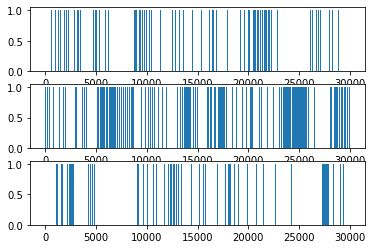

In [101]:
fig, ax = plt.subplots(3)
ax[0].bar(np.arange(ty.shape[0]), ty[:, 0])
ax[1].bar(np.arange(ty.shape[0]), ty[:, 1])
ax[2].bar(np.arange(ty.shape[0]), ty[:, 2])

In [102]:
check = [0, 0, 0, 0]
for i in range(len(ty)):
    if ty[i, 1]==1:
        check[1]+=1
    elif ty[i, 0]==1:
        check[0]+=1
    elif ty[i, 2]==1:
        check[2]+=1
    else:
        check[3]+=1
check[0]/len(ty), check[1]/len(ty), check[2]/len(ty), check[3]/len(ty)

(0.2558364461045891, 0.48249066168623267, 0.2616728922091782, 0.0)

In [109]:
lookback

200

In [110]:
leviathan = modeller(lookback)
check_path = "check/leviathan.ckpt"
check_dir = os.path.dirname(check_path)
epochs = 50
batch_size = 300
leviathan.fit(tx, ty, epochs=epochs, batch_size=batch_size,  callbacks=[keras.callbacks.ReduceLROnPlateau(
            monitor="accuracy", factor=0.5, patience=5, min_lr=0.0001), keras.callbacks.ModelCheckpoint(filepath=check_path)])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_50 (GRU)                (None, 200, 28)           2604      
                                                                 
 gru_51 (GRU)                (None, 200, 28)           4872      
                                                                 
 gru_52 (GRU)                (None, 200, 28)           4872      
                                                                 
 gru_53 (GRU)                (None, 200, 28)           4872      
                                                                 
 gru_54 (GRU)                (None, 24)                3888      
                                                                 
 dense_30 (Dense)            (None, 16)                400       
                                                                 
 dense_31 (Dense)            (None, 16)              

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 483s 5s/step - loss: 1.0572 - accuracy: 0.4791 - lr: 0.0050
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.0430 - accuracy: 0.4883

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 465s 5s/step - loss: 1.0430 - accuracy: 0.4883 - lr: 0.0050
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.4825

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 447s 4s/step - loss: 1.0525 - accuracy: 0.4825 - lr: 0.0050
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 1.0278 - accuracy: 0.4995

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 599s 6s/step - loss: 1.0278 - accuracy: 0.4995 - lr: 0.0050
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.5340

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 581s 6s/step - loss: 0.9610 - accuracy: 0.5340 - lr: 0.0050
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.5484

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 580s 6s/step - loss: 0.9279 - accuracy: 0.5484 - lr: 0.0050
Epoch 7/50
100/100 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.5654

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 679s 7s/step - loss: 0.9069 - accuracy: 0.5654 - lr: 0.0050
Epoch 8/50
100/100 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.5768

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 649s 6s/step - loss: 0.8814 - accuracy: 0.5768 - lr: 0.0050
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.6131

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 614s 6s/step - loss: 0.8410 - accuracy: 0.6131 - lr: 0.0050
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 0.7987 - accuracy: 0.6409

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 632s 6s/step - loss: 0.7987 - accuracy: 0.6409 - lr: 0.0050
Epoch 11/50
100/100 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6710

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 756s 8s/step - loss: 0.7473 - accuracy: 0.6710 - lr: 0.0050
Epoch 12/50
100/100 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6893

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 754s 8s/step - loss: 0.7348 - accuracy: 0.6893 - lr: 0.0050
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.7223

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 756s 8s/step - loss: 0.6476 - accuracy: 0.7223 - lr: 0.0050
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7581

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 923s 9s/step - loss: 0.5868 - accuracy: 0.7581 - lr: 0.0050
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7868

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 702s 7s/step - loss: 0.5134 - accuracy: 0.7868 - lr: 0.0050
Epoch 16/50
100/100 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.8004

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 717s 7s/step - loss: 0.4844 - accuracy: 0.8004 - lr: 0.0050
Epoch 17/50
100/100 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8209

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 762s 8s/step - loss: 0.4389 - accuracy: 0.8209 - lr: 0.0050
Epoch 18/50
100/100 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8372

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 763s 8s/step - loss: 0.4028 - accuracy: 0.8372 - lr: 0.0050
Epoch 19/50
100/100 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8388

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 797s 8s/step - loss: 0.3921 - accuracy: 0.8388 - lr: 0.0050
Epoch 20/50
100/100 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8526

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 906s 9s/step - loss: 0.3545 - accuracy: 0.8526 - lr: 0.0050
Epoch 21/50
100/100 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8710

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 807s 8s/step - loss: 0.3222 - accuracy: 0.8710 - lr: 0.0050
Epoch 22/50
100/100 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8654

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 808s 8s/step - loss: 0.3267 - accuracy: 0.8654 - lr: 0.0050
Epoch 23/50
100/100 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.8588

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 824s 8s/step - loss: 0.3626 - accuracy: 0.8588 - lr: 0.0050
Epoch 24/50
100/100 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8886

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 808s 8s/step - loss: 0.2819 - accuracy: 0.8886 - lr: 0.0050
Epoch 25/50
100/100 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8790

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 810s 8s/step - loss: 0.3050 - accuracy: 0.8790 - lr: 0.0050
Epoch 26/50
100/100 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8929

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 834s 8s/step - loss: 0.2653 - accuracy: 0.8929 - lr: 0.0050
Epoch 27/50
100/100 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8951

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 763s 8s/step - loss: 0.2683 - accuracy: 0.8951 - lr: 0.0050
Epoch 28/50
100/100 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.8986

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 780s 8s/step - loss: 0.2504 - accuracy: 0.8986 - lr: 0.0050
Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9082

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 813s 8s/step - loss: 0.2326 - accuracy: 0.9082 - lr: 0.0050
Epoch 30/50
100/100 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9095

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 815s 8s/step - loss: 0.2233 - accuracy: 0.9095 - lr: 0.0050
Epoch 31/50
100/100 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9139

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 945s 9s/step - loss: 0.2137 - accuracy: 0.9139 - lr: 0.0050
Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9109 

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 1078s 11s/step - loss: 0.2140 - accuracy: 0.9109 - lr: 0.0050
Epoch 33/50
100/100 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8997

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 773s 8s/step - loss: 0.2787 - accuracy: 0.8997 - lr: 0.0050
Epoch 34/50
100/100 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9199

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 773s 8s/step - loss: 0.2110 - accuracy: 0.9199 - lr: 0.0050
Epoch 35/50
100/100 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9208

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 865s 9s/step - loss: 0.1975 - accuracy: 0.9208 - lr: 0.0050
Epoch 36/50
100/100 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9235

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 842s 8s/step - loss: 0.1912 - accuracy: 0.9235 - lr: 0.0050
Epoch 37/50
100/100 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9259

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 858s 9s/step - loss: 0.1862 - accuracy: 0.9259 - lr: 0.0050
Epoch 38/50
100/100 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9269

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 970s 10s/step - loss: 0.1926 - accuracy: 0.9269 - lr: 0.0050
Epoch 39/50
100/100 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9294

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 971s 10s/step - loss: 0.1786 - accuracy: 0.9294 - lr: 0.0050
Epoch 40/50
100/100 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9296

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 1012s 10s/step - loss: 0.1804 - accuracy: 0.9296 - lr: 0.0050
Epoch 41/50
100/100 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9349 

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 1091s 11s/step - loss: 0.1600 - accuracy: 0.9349 - lr: 0.0050
Epoch 42/50
100/100 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9343

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 915s 9s/step - loss: 0.1669 - accuracy: 0.9343 - lr: 0.0050
Epoch 43/50
100/100 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9347

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 915s 9s/step - loss: 0.1614 - accuracy: 0.9347 - lr: 0.0050
Epoch 44/50
100/100 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9373

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 938s 9s/step - loss: 0.1544 - accuracy: 0.9373 - lr: 0.0050
Epoch 45/50
100/100 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9370

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 902s 9s/step - loss: 0.1577 - accuracy: 0.9370 - lr: 0.0050
Epoch 46/50
100/100 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9404

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 900s 9s/step - loss: 0.1428 - accuracy: 0.9404 - lr: 0.0050
Epoch 47/50
100/100 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9396

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 958s 10s/step - loss: 0.1568 - accuracy: 0.9396 - lr: 0.0050
Epoch 48/50
100/100 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9378

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 836s 8s/step - loss: 0.1637 - accuracy: 0.9378 - lr: 0.0050
Epoch 49/50
100/100 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9399

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 854s 9s/step - loss: 0.1519 - accuracy: 0.9399 - lr: 0.0050
Epoch 50/50
100/100 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9400

INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


INFO:tensorflow:Assets written to: check\leviathan.ckpt\assets


100/100 [==============================] - 983s 10s/step - loss: 0.1523 - accuracy: 0.9400 - lr: 0.0050


In [111]:
#acc = 0
#for i in prediction:
#    acc += i
    
#print(acc/len(prediction))

preparing x and y...
122/122 [==============================] - 12s 101ms/step


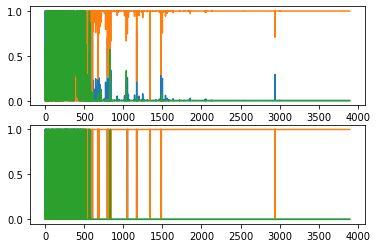

In [116]:
new_list = ["bajaj finserv.csv", "rpow.csv"]
list_of_options = ["Spread Close-Open"]
checkx, checky = data_prep(new_list, list_of_options, lookback, lookforward)
final = leviathan.predict(checkx)
fig, ax = plt.subplots(2)
ax[0].plot(final)
ax[1].plot(checky)
#prediction = predictor(model1, checkx, checky, lookback)
#vals = np.zeros(prediction.shape[0])
#acc = 0

#for k in range(prediction.shape[0]):
#    if (np.where(prediction[k]==max(prediction[k]))[0][0]==np.where(checky[k]==max(checky[k]))[0][0]):
#        vals[k] = 1
#    else:
#        vals[k] = 0
    
#for i in vals:
#    acc+=i

#plt.bar(np.arange(prediction.shape[0]), vals)
#print("Accuracy on random dataset: ", acc/len(vals))

In [120]:
vals = np.zeros(final.shape[0])
acc=0
confi = np.zeros(final.shape[0])
for k in range(final.shape[0]):
    confi[k] = max(final[k])
    if (np.where(final[k]==max(final[k]))[0][0]==np.where(checky[k]==max(checky[k]))[0][0]):
        vals[k] = 1
    else:
        vals[k] = 0
    
for i in vals:
    acc+=i


Accuracy on random dataset:  0.9697280656747049


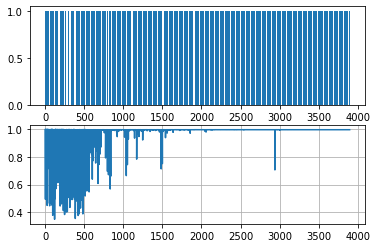

In [126]:
fig, ax = plt.subplots(2)
ax[0].bar(np.arange(final.shape[0]), vals)
ax[1].plot(confi)
#ax[1].y_ticks(np.arange(0, 1, 0.05))
ax[1].grid()
print("Accuracy on random dataset: ", acc/len(vals))

In [119]:
end = time()
print("Time taken to run notebook: ", (end-start)/60, " minutes")

Time taken to run notebook:  940.7702295263608  minutes


Case 1:5 GRUs and 3 Dense-activation is leaky_relu
Case 1 accuracy = 90.909%
Case 2: 5 GRUs and 2 Dense-activation is leaky_relu
Case 2 accuracy = 87.272%
Case 3: 5 GRUs and 3 Dense-activation is tanh
Case 3 accuracy = 96.363%
Case 4: Case 3 with lookforward of 10 days
Case 4 accuracy = 68.881%